# Homework 5

## Due Wednesday 26 October, before class

### PHYS 440/540, Fall 2022
https://github.com/gtrichards/PHYS_440_540/


## Problems 1&2

Complete Chapters 1 and 2 in the *unsupervised learning* course in Data Camp.  The last video (and the two following code examples) in Chapter 2 are off topic, but we'll discuss those next week, so this will be a good intro.  The rest is highly relevant to this week's material.  These are worth 1000 and 900 points, respectively.  I'll be grading on the number of points earned instead of completion (as I have been), so try to avoid using the hints unless you really need them.

## Problem 3

Fill in the blanks below.  This exercise will take you though an example of everything that we did this week.  Please copy the relevant import statements (below) to the cells where they are used (so that they can be run out of order).  

If a question is calling for a word-based answer, I'm not looking for more than ~1 sentence.

---

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import homogeneity_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

Setup up the data set.  We will do both density estimation and clustering on it.

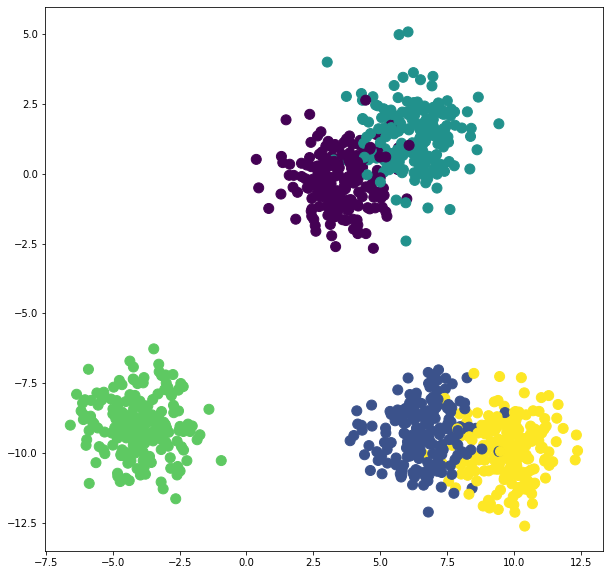

In [5]:
from sklearn.datasets import make_blobs
#Make two blobs with 2 features and 1000 samples
N=1000
X,y = make_blobs(n_samples=N, centers=5, n_features=2, random_state=99)
plt.figure(figsize=(10,10))
plt.scatter(X[:, 0], X[:, 1], s=100, c=y)

Start with a gaussian kernel density estimation, including a grid search to find the best bandwidth

0.4813559322033899


C:\Users\evan\AppData\Local\Temp\ipykernel_24592\2196984279.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T


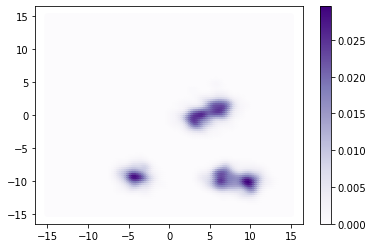

In [8]:
bwrange = np.linspace(0.1,1,60) # Test 60 bandwidths from 0.1 to 1.0 ####
K = 5 # 5-fold cross validation ####
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) ####
grid.fit(X) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth'] ####
print(h_opt)

kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(X) #fit the model to the data

u = v = np.linspace(-15,15,100)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(u, v))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens, cmap="Purples", edgecolor="None") ####
plt.colorbar()

---

Now try a nearest neighbors approach to estimating the density. 

#### What value of $k$ do you need to make the plot look similar to the one above?

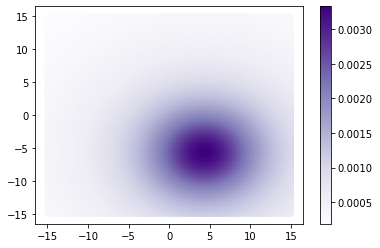

In [9]:
# Compute density with Bayesian nearest neighbors
k=1000 ####
nbrs = KNeighborsDensity('bayesian',n_neighbors=k) ####
nbrs.fit(X) ####
dens_nbrs = nbrs.eval(Xgrid) / N

plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_nbrs, cmap="Purples", edgecolor="None")
plt.colorbar()

---

Now do a Gaussian mixture model.  Do a grid search for between 1 and 10 components.

In [10]:
#Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

1


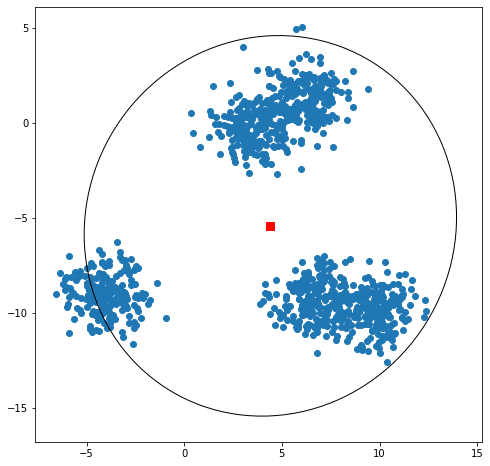

In [11]:
ncomps = np.arange(1,10,10) # Test 10 bandwidths from 1 to 10 ####
K = 5 # 5-fold cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': ncomps}, cv=K)  ####
grid.fit(X) #Fit the histogram data that we started the lecture with.
ncomp_opt = grid.best_params_['n_components'] ####
print(ncomp_opt)

gmm = GaussianMixture(n_components=ncomp_opt) ####
gmm.fit(X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(X[:,0],X[:,1])

ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='s', c='red', s=80)
for mu, C, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(mu, 1*C, scales=[2], ax=ax, fc='none', ec='k') #2 sigma ellipses for each component

#### Do you get the same answer (the same number of components) each time you run it?

---

Now try Kmeans.  Here we will scale the data.

In [36]:
kmeans = KMeans(n_clusters=3)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) ####
kmeans.fit(X_scaled)
centers=kmeans.cluster_centers_ #location of the clusters ####
labels=kmeans.predict(X_scaled) #labels for each of the points ####
centers_unscaled = scaler.inverse_transform(centers) ####

Text(0.5, 1.0, 'Truth')

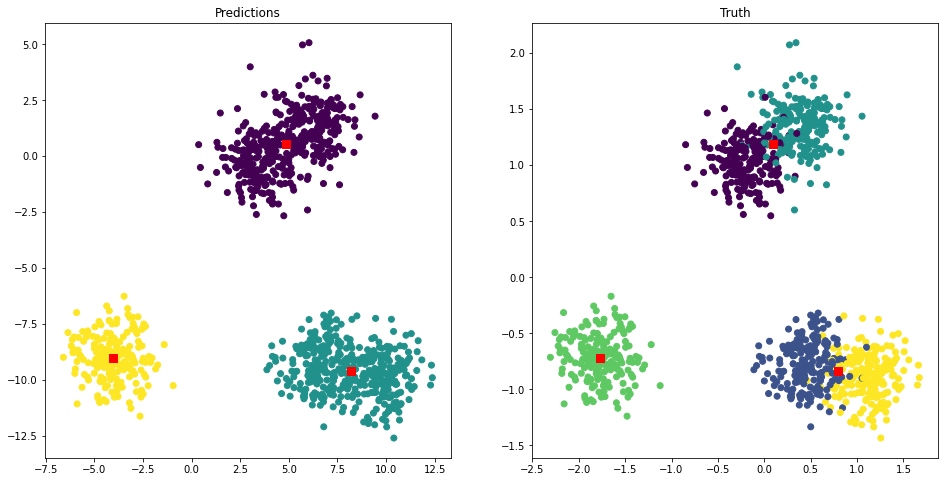

In [37]:
fig,ax = plt.subplots(1,2,figsize=(16, 8))
ax[0].scatter(X[:,0],X[:,1],c=labels)
ax[0].scatter(centers_unscaled[:,0], centers_unscaled[:,1], marker='s', c='red', s=80)
ax[0].set_title("Predictions")

ax[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y)
ax[1].scatter(centers[:,0], centers[:,1], marker='s', c='red',s=80)
ax[1].set_title("Truth")

Let's evaluate how well we did in two other ways: a matrix and a score.

In [41]:
import pandas as pd
df = pd.DataFrame({'predictions': labels, 'truth': y})
ct = pd.crosstab(df['truth'], df['predictions'])
print(ct)

predictions    0    1    2
truth                     
0            200    0    0
1              0  200    0
2            200    0    0
3              0    0  200
4              0  200    0


In [43]:
from sklearn.metrics.cluster import homogeneity_score
score = homogeneity_score(df['truth'], df['predictions'])
print(score)

0.6554587535412854


#### What is the score for 3 clusters?

---

Finally, let's use DBSCAN.  Note that outliers are flagged as `labels_=-1`, so there is one more class that you might think.

Full credit if you can get a score of 0.6 or above.  Extra credit (0.1 of 5 points) for a score of 0.85 or above.


In [40]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

5


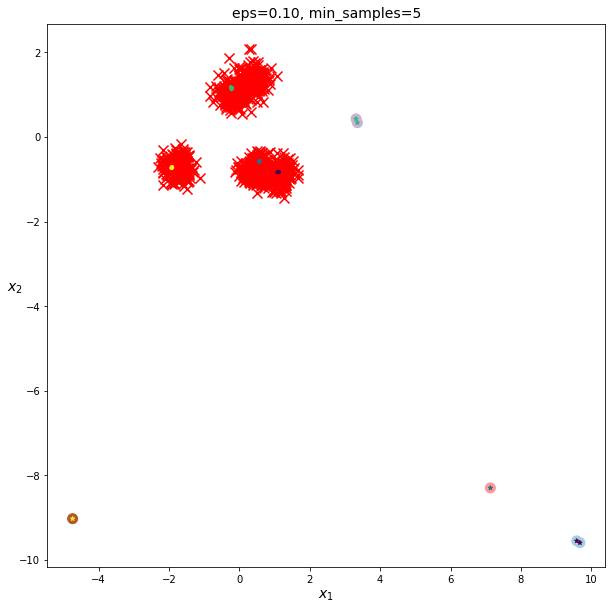

In [58]:
dbscan = DBSCAN(eps=0.1, min_samples=5,metric='euclidean')
dbscan.fit(X)

plt.figure(figsize=(10, 10))
plot_dbscan(dbscan, X_scaled, size=100)
n_clusters=np.unique(dbscan.labels_)
print(len(n_clusters)) #Number of clusters found (+1)

In [59]:
df2 = pd.DataFrame({'predictions': dbscan.labels_, 'truth': y})
ct2 = pd.crosstab(df2['predictions'], df2['truth'])
print(ct2)

truth          0    1    2    3    4
predictions                         
-1           194  195  199  195  194
 0             0    0    0    0    6
 1             0    5    0    0    0
 2             6    0    1    0    0
 3             0    0    0    5    0


In [60]:
from sklearn.metrics.cluster import homogeneity_score
score2 = homogeneity_score(df2['truth'],df2['predictions'])
print(score2)

0.02124349909539594


#### Why do you think DBSCAN is having a hard time?  Think about what the Gaussian Mixture Model result showed.